In [1]:
import pandas as pd

# Read csv
df = pd.read_csv('C:\\Users\\DianaEspinosaLozano\\anaconda3\\envs\\thesis\\elecdemandhourly240723.csv')

# Battery parameters
battery_capacity = 10  # kWh
c_rate = 1
charge_efficiency = 0.96 # BYD HVS & HVM
discharge_efficiency = 0.96
charging_power = c_rate * battery_capacity * charge_efficiency # kW
min_soc = 1
max_soc = battery_capacity
battery_soc = 5  # Initial state of charge in kWh (50% of battery capacity)
charge_efficiency = 0.96 # BYD HVS & HVM
discharge_efficiency = 0.96

# Adding columns to the DataFrame for the simulation results
df['battery_soc'] = 0.0
df['battery_charge'] = 0.0
df['battery_discharge'] = 0.0
df['grid_export'] = 0.0
df['pv_excess'] = 0.0
df['grid_import'] = 0.0
df['eigenverbrauch'] = 0.0

# Simulation loop
for i in range(len(df)):
    pv_production = df.loc[i, 'pv']
    ac_consumption = df.loc[i, 'h0_dyn'] # Verbrauchsstromprofil

    if pv_production >= ac_consumption:
        # Surplus PV production
        surplus = pv_production - ac_consumption

        # Charge the battery with the surplus, limited by the charging power and max_soc
        charge_potential = surplus * charge_efficiency
        charge_to_battery = min(charge_potential, max_soc - battery_soc)

        # Update battery state of charge
        battery_soc += charge_to_battery

        # Calculate excess PV after charging battery
        pv_excess = surplus - (charge_to_battery / charge_efficiency)

        # Energy to be exported to the grid
        grid_export = pv_excess

        # Update DataFrame
        df.loc[i, 'battery_charge'] = charge_to_battery
        df.loc[i, 'grid_export'] = grid_export
        df.loc[i, 'pv_excess'] = pv_excess
        df.loc[i, 'grid_import'] = 0.0  # No grid import in surplus case
        df.loc[i, 'eigenverbrauch'] = ac_consumption

    else:
        # PV production is less than AC consumption
        shortfall = ac_consumption - pv_production

        # Discharge battery to meet the shortfall, limited by discharging power and min_soc
        discharge_needed = min(shortfall / discharge_efficiency, charging_power)
        discharge_from_battery = min(discharge_needed, battery_soc-min_soc)

        # Actual energy supplied to AC from battery
        energy_from_battery = discharge_from_battery * discharge_efficiency

       
        # Update battery state of charge
        battery_soc -= discharge_from_battery
       
        # Calculate any remaining shortfall after battery discharge
        remaining_shortfall = shortfall - energy_from_battery

        # Energy imported from the grid to cover the remaining shortfall
        grid_import = remaining_shortfall if remaining_shortfall > 0 else 0.0

        # Update DataFrame
        df.loc[i, 'battery_discharge'] = discharge_from_battery
        df.loc[i, 'grid_import'] = grid_import
        df.loc[i, 'grid_export'] = 0.0  # No grid export in deficit case
        df.loc[i, 'pv_excess'] = 0.0  # No excess PV in deficit case
        df.loc[i, 'eigenverbrauch'] = energy_from_battery + pv_production

    # Update SOC in the DataFrame
    df.loc[i, 'battery_soc'] = battery_soc

# Optional: Set battery_soc to not exceed capacity or drop below 0
# df['battery_soc'] = df['battery_soc'].clip(lower=min_soc, upper=max_soc)

# Display the DataFrame with the results
# print(df)


In [2]:
x = 0
i = 0
for i in range(len(df)):
    pv_production = df.loc[i, 'pv']
    if pv_production >= 9.3:
        x = x + 1
        y = i

y

2051

In [3]:
import datetime
import datetime 
year = 2016 
df.set_index(pd.date_range(datetime.datetime(year, 1, 1, 0), periods= len(df), freq="h"), inplace=True)
df = df.drop(df.columns[0], axis=1)
df

,h0_dyn,pv,sub,Netzbezug,Eigenverbrauch,Einspeisung,battery_soc,battery_charge,battery_discharge,grid_export,pv_excess,grid_import,eigenverbrauch
2016-01-01 00:00:00,0.386959,0.0,-0.386959,0.386959,0.0,0.0,4.596917,0.0,0.403083,0.0,0.0,0.000000,0.386959
2016-01-01 01:00:00,0.278753,0.0,-0.278753,0.278753,0.0,0.0,4.306550,0.0,0.290368,0.0,0.0,0.000000,0.278753
2016-01-01 02:00:00,0.223167,0.0,-0.223167,0.223167,0.0,0.0,4.074084,0.0,0.232465,0.0,0.0,0.000000,0.223167
2016-01-01 03:00:00,0.203622,0.0,-0.203622,0.203622,0.0,0.0,3.861977,0.0,0.212107,0.0,0.0,0.000000,0.203622
2016-01-01 04:00:00,0.191801,0.0,-0.191801,0.191801,0.0,0.0,3.662185,0.0,0.199793,0.0,0.0,0.000000,0.191801
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1.061405,0.0,-1.061405,1.061405,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,1.061405,0.000000
2016-12-31 20:00:00,0.868713,0.0,-0.868713,0.868713,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.868713,0.000000
2016-12-31 21:00:00,0.677457,0.0,-0.677457,0.677457,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.677457,0.000000
2016-12-31 22:00:00,0.618953,0.0,-0.618953,0.618953,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.618953,0.000000


In [4]:
# df to csv
df.to_csv('df_pv_bs_240906.csv')

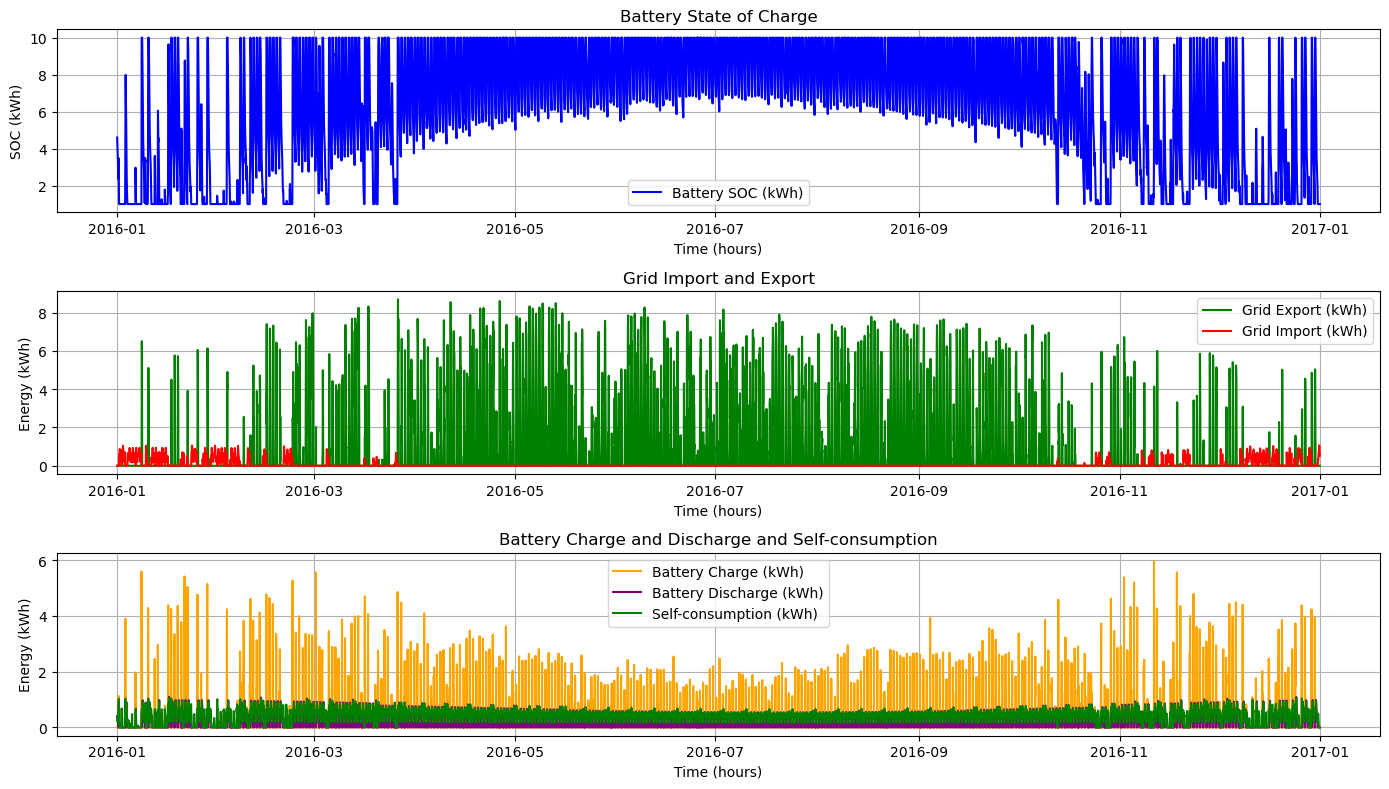

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))

# Plot SOC
plt.subplot(3, 1, 1)
plt.plot(df['battery_soc'], label='Battery SOC (kWh)', color='blue')
plt.xlabel('Time (hours)')
plt.ylabel('SOC (kWh)')
plt.title('Battery State of Charge')
plt.legend()
plt.grid(True)

# Plot Grid Import and Export
plt.subplot(3, 1, 2)
plt.plot(df['grid_export'], label='Grid Export (kWh)', color='green')
plt.plot(df['grid_import'], label='Grid Import (kWh)', color='red')
plt.xlabel('Time (hours)')
plt.ylabel('Energy (kWh)')
plt.title('Grid Import and Export')
plt.legend()
plt.grid(True)

# Plot Battery Charge and Discharge
plt.subplot(3, 1, 3)
plt.plot(df['battery_charge'], label='Battery Charge (kWh)', color='orange')
plt.plot(df['battery_discharge'], label='Battery Discharge (kWh)', color='purple')
plt.plot(df['eigenverbrauch'], label = 'Self-consumption (kWh)', color = 'green')
plt.xlabel('Time (hours)')
plt.ylabel('Energy (kWh)')
plt.title('Battery Charge and Discharge and Self-consumption')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Jahressumme + Ersparnis

In [6]:
# Jahresertrag
pv = round(sum(df['pv']))

# Netzbezug
netzbezug = round(sum(df['grid_import']))

# Einspeisung
einspeisung = round(sum(df['grid_export']))

# Eingenverbrauch der PV-Produktion
eigenverbrauch = pv - einspeisung - netzbezug
eigenverbrauch_genau = round(sum(df['eigenverbrauch']))

# Summe der aufgeladener Energie im Batteriespeicher 
batterie = round(sum(df['battery_charge']))

# Direkter Verbrauch an PV-Strom
pv_direkt = eigenverbrauch - batterie

# Stromkosten mit PV
# Strompreis 2024: 41,35 Cent/kWh (https://www.bdew.de/service/daten-und-grafiken/bdew-strompreisanalyse/)
strompreis = 0.4135
stromkosten = round(netzbezug * strompreis, 2)


# Stromkosten ohne PV
verbrauch = round(sum(df['h0_dyn']), 2)
stromkosten_ohne_pv = round(verbrauch * strompreis, 2)

# Einspeisevergütung - Gewinn
# Einspeisevergütung 2024: Feb-Aug: 8,1 ct, Aug-Feb25: 8 ct (https://photovoltaik.org/kosten/einspeiseverguetung)
einspeiseverguetung = 0.08
verguetung = round(einspeisung * einspeiseverguetung, 2)

# Ersparnis
einsparung = round(stromkosten_ohne_pv - (stromkosten - verguetung), 2)

# Print
print('Jahresertrag in kWh: ', pv)
print('Eigenverbrauch in kWh: ', eigenverbrauch)
print('Eigenverbrauch (genau) in kWh: ', eigenverbrauch_genau)
print('Geladene PV-Strom in Batteriespeicher in kWh: ', batterie)
print('Direkter Verbrauch PV-Strom in kWh: ', pv_direkt)
print('')
print('Netzbezug in kWh: ', netzbezug)
print('Einspeisung ins Netz in kWh: ', einspeisung)
print('')
print('Stromkosten ohne PV in €/a: ', stromkosten_ohne_pv)
print('Stromkosten mit PV & BS in €/a: ', stromkosten)
print('Einspeisevergütung in €/a: ', verguetung)
print('Stromkosten Einsparung in €/a: ', einsparung)

Jahresertrag in kWh:  11267
Eigenverbrauch in kWh:  3124
Eigenverbrauch (genau) in kWh:  3495
Geladene PV-Strom in Batteriespeicher in kWh:  1713
Direkter Verbrauch PV-Strom in kWh:  1411

Netzbezug in kWh:  508
Einspeisung ins Netz in kWh:  7635

Stromkosten ohne PV in €/a:  1655.35
Stromkosten mit PV & BS in €/a:  210.06
Einspeisevergütung in €/a:  610.8
Stromkosten Einsparung in €/a:  2056.09


## Plots

<function matplotlib.pyplot.show(close=None, block=None)>

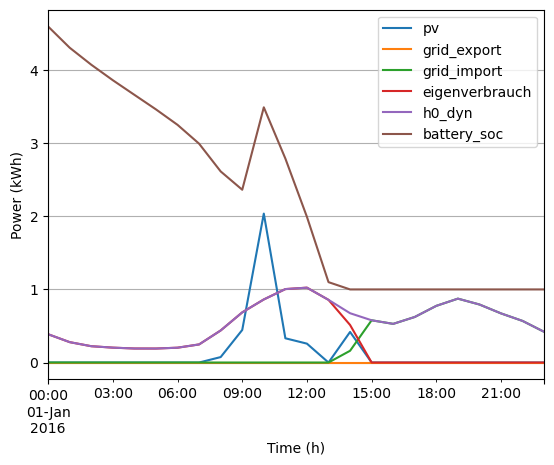

In [7]:
# 1 Tag: 1.1.2016
tag = df.loc['2016-01-01 00:00:00':'2016-01-01 23:00:00', ['pv','grid_export', 'grid_import', 'eigenverbrauch', 'h0_dyn','battery_soc']]
tag_plot = tag.plot()
tag_plot.set_xlabel('Time (h)')
tag_plot.set_ylabel('Power (kWh)')
plt.grid(True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

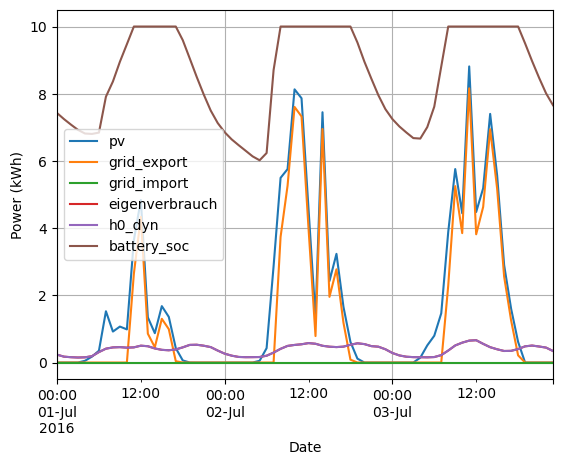

In [14]:
# 1 Tag: 1.7.2016
tag = df.loc['2016-07-01 00:00:00':'2016-07-03 23:00:00', ['pv','grid_export', 'grid_import','eigenverbrauch','h0_dyn','battery_soc']]
tag_plot = tag.plot()
tag_plot.set_xlabel('Date')
tag_plot.set_ylabel('Power (kWh)')
plt.grid(True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

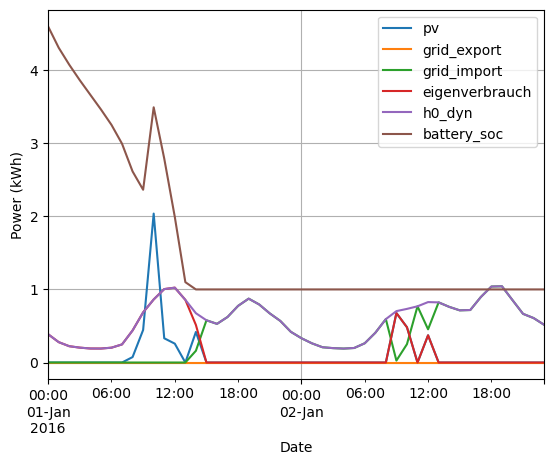

In [13]:
# 1 Tag: 1.7.2016
tag = df.loc['2016-01-01 00:00:00':'2016-01-03 23:00:00', ['pv','grid_export', 'grid_import','eigenverbrauch','h0_dyn','battery_soc']]
tag_plot = tag.plot()
tag_plot.set_xlabel('Date')
tag_plot.set_ylabel('Power (kWh)')
plt.grid(True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

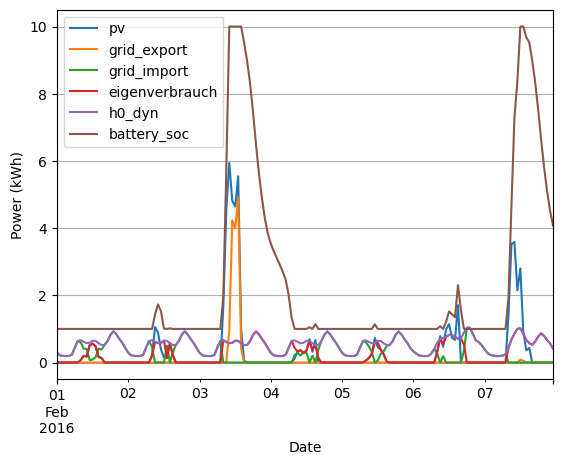

In [9]:
# 1 Woche: 1.7.2016
tag = df.loc['2016-02-01 00:00:00':'2016-02-07 23:00:00', ['pv','grid_export', 'grid_import', 'eigenverbrauch', 'h0_dyn','battery_soc']]
tag_plot = tag.plot()
tag_plot.set_xlabel('Date')
tag_plot.set_ylabel('Power (kWh)')
plt.grid(True)
plt.show

In [10]:
column = []
jahr = pd.DataFrame(column)
jahr['pv'] = df['pv'].resample('W').mean
jahr['pv'].info



<bound method Series.info of Series([], Name: pv, dtype: object)>

In [11]:
x = 0
i = 0
for timestamp in df.index:
    pv_production = df.loc[timestamp, 'pv']
    if pv_production > 9.3:
        x = x+1
        y = timestamp
y # PV ist nie über 10 kWp

Timestamp('2016-03-26 11:00:00')

In [12]:
len(df)

8784